In [20]:
import os
import tarfile
import pickle
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm # progress bar to follow the extraction
from torchvision import transforms

In [21]:
# Let's begin with extracting the files from the .tar file

# Path to train.tar file and extract path
file_path = "./cifar-10-python.tar.gz"
extract_path = "./cifar-10-python" 

# Create the target directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Function to check if a directory is empty
def is_directory_empty(directory):
    return not any(os.scandir(directory))

# Check if the target directory is empty
if is_directory_empty(extract_path):
    # Extract the files only if the directory is empty
    with tarfile.open(file_path, 'r') as tar:
        # Use tqdm to create a progress bar, so we can follow the extraction progress
        progress_bar = tqdm(tar.getmembers(), desc="Extracting")
        
        # Extract all files
        for member in progress_bar:
            tar.extract(member, path=extract_path)
            progress_bar.update(1)  # Update the progress bar

    print(f"Successfully extracted '{file_path}' to '{extract_path}'.")
else:
    print("Files have already been extracted.")
    

Files have already been extracted.


In [22]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict[b'data'], dict[b'labels']

# Load the data to memory

training_batch_1 = "cifar-10-python/cifar-10-batches-py/data_batch_1"
training_batch_2 = "cifar-10-python/cifar-10-batches-py/data_batch_2"
training_batch_3 = "cifar-10-python/cifar-10-batches-py/data_batch_3"
training_batch_4 = "cifar-10-python/cifar-10-batches-py/data_batch_4"
training_batch_5 = "cifar-10-python/cifar-10-batches-py/data_batch_5"
test_batch = "cifar-10-python/cifar-10-batches-py/test_batch"

training_data_1, training_labels_1 = unpickle(training_batch_1)
training_data_2, training_labels_2 = unpickle(training_batch_2)
training_data_3, training_labels_3 = unpickle(training_batch_3)
training_data_4, training_labels_4 = unpickle(training_batch_4)
training_data_5, training_labels_5 = unpickle(training_batch_5)
testing_data, testing_labels = unpickle(test_batch)

# Concatenate the training data and labels into one large dataset
training_data = np.concatenate([training_data_1, training_data_2, training_data_3, training_data_4, training_data_5])
training_labels = np.concatenate([training_labels_1, training_labels_2, training_labels_3, training_labels_4, training_labels_5])

# Ensure that testing data and labels are also np.array
testing_data = np.array(testing_data)
testing_labels = np.array(testing_labels)


In [23]:
# let's select all classes the dataset has
# According to the readme, it's 10. Therefore
selected_classes = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# choose the data from the classes
train_mask = np.isin(training_labels, selected_classes)
training_data = training_data[train_mask]
training_labels = training_labels[train_mask]

test_mask = np.isin(testing_labels, selected_classes)
testing_data = testing_data[test_mask]
testing_labels = testing_labels[test_mask]

# split the training data to a new training data and validation data
class_indices = [[] for i in range(10)]
for i, v in enumerate(training_labels):
    class_indices[v].append(i)

# randomize the order of indices
indices_all = np.random.permutation(len(class_indices[0]))
# take the first 1000 indices of indices_all
indices = indices_all[:1000]
# take the rest of the indices of indices_all
indices_rest = indices_all[1000:]

validation_indices = []
training_indices = []
for i in range(10):
    validation_indices.extend(np.array(class_indices[i])[indices])
    training_indices.extend(np.array(class_indices[i])[indices_rest])

# write the custom dataset based on the dataset
class cifar10(Dataset):
    """cifar10 dataset"""

    def __init__(self, phase='train', transform=None):

        if phase == 'train':
            self.data = training_data[training_indices]
            self.label = training_labels[training_indices]

        elif phase == 'validation':
            self.data = training_data[validation_indices]
            self.label = training_labels[validation_indices]

        elif phase == 'test':
            self.data = testing_data
            self.label = testing_labels

        else:
            raise ValueError('Invalid phase.')

        self.transform = transform

        self.label_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        # Get image and label according to the index
        img, label = self.data[index], self.label[index]

        # Convert image to PyTorch tensor and normalize
        img = img.astype(np.float32) / 255.0  # Convert to float and normalize
        img = np.transpose(img.reshape(3, 32, 32), (1, 2, 0))  # Reshape and transpose to (H, W, C)
            
        if self.transform is not None:
            img = self.transform(img)

        return img, label
        

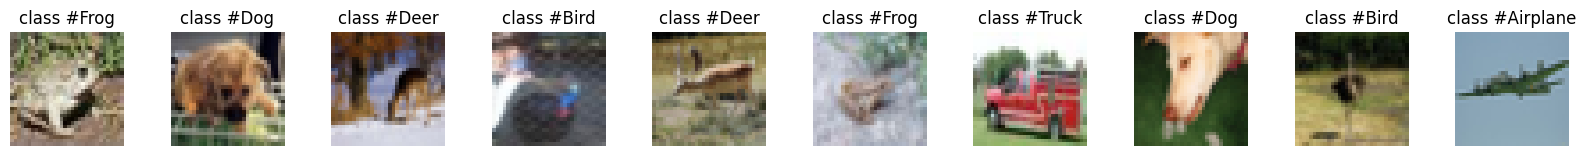

total number of training set: 40000
number of images for class Airplane: 4000
number of images for class Automobile: 4000
number of images for class Bird: 4000
number of images for class Cat: 4000
number of images for class Deer: 4000
number of images for class Dog: 4000
number of images for class Frog: 4000
number of images for class Horse: 4000
number of images for class Ship: 4000
number of images for class Truck: 4000


In [24]:
# check test, train and validation sets
# randomly show some samples and their labels to see that labeling works
training_set = cifar10(phase='train', transform=None)

num_to_show = 10
idx = np.random.choice(range(len(training_set)), num_to_show, replace=False) # randomly pick 10 pictures to show

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = training_set[idx[i]] 
    label_name = training_set.label_names[label]

    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(image)

plt.show()

# print number of images for each class
print('total number of training set: {}'.format(len(training_set)))
for i in range(10):
    print('number of images for class {}: {}'.format(training_set.label_names[i], np.sum(training_set.label==i)))

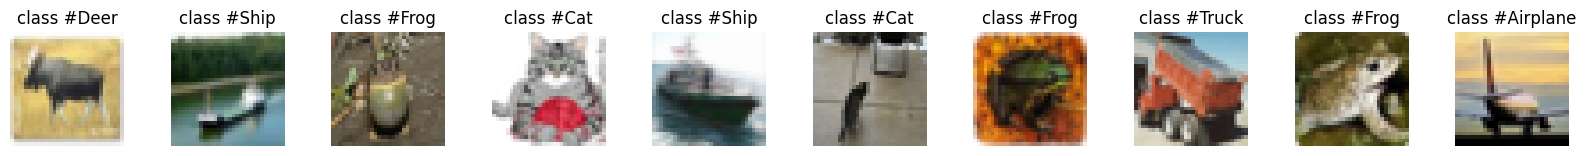

total number of testing set: 10000
number of images for class Airplane: 1000
number of images for class Automobile: 1000
number of images for class Bird: 1000
number of images for class Cat: 1000
number of images for class Deer: 1000
number of images for class Dog: 1000
number of images for class Frog: 1000
number of images for class Horse: 1000
number of images for class Ship: 1000
number of images for class Truck: 1000


In [25]:
# randomly show some samples and their labels to see that labeling works
testing_set = cifar10(phase='test', transform=None)

num_to_show = 10
idx = np.random.choice(range(len(testing_set)), num_to_show, replace=False) # randomly pick 10 pictures to show

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = testing_set[idx[i]] 
    label_name = testing_set.label_names[label]

    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(image)

plt.show()

# print number of images for each class
print('total number of testing set: {}'.format(len(testing_set)))
for i in range(10):
    print('number of images for class {}: {}'.format(testing_set.label_names[i], np.sum(testing_set.label==i)))



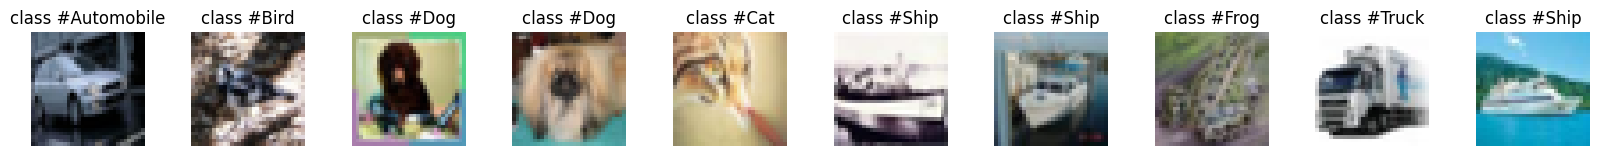

total number of validation set: 10000
number of images for class Airplane: 1000
number of images for class Automobile: 1000
number of images for class Bird: 1000
number of images for class Cat: 1000
number of images for class Deer: 1000
number of images for class Dog: 1000
number of images for class Frog: 1000
number of images for class Horse: 1000
number of images for class Ship: 1000
number of images for class Truck: 1000


In [26]:
# randomly show some samples and their labels to see that labeling works
validation_set = cifar10(phase='validation', transform=None)

num_to_show = 10
idx = np.random.choice(range(len(validation_set)), num_to_show, replace=False) # randomly pick 10 pictures to show

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = validation_set[idx[i]] 
    label_name = validation_set.label_names[label]

    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(image)

plt.show()

# print number of images for each class
print('total number of validation set: {}'.format(len(validation_set)))
for i in range(10):
    print('number of images for class {}: {}'.format(validation_set.label_names[i], np.sum(validation_set.label==i)))

In [48]:
# transform the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # normalize to pixel values to range [-1, 1]
])

batch_size = 512
num_workers = 0

# sets and loaders, shuffle training set
training_set = cifar10(phase='train', transform=transform)
testing_set = cifar10(phase='test', transform=transform)
validation_set = cifar10(phase='validation', transform=transform)

training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
testing_loader = DataLoader(testing_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [28]:
# simple CNN model, similar to one we did in our DL course
class Network(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(2304, batch_size)
        
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(batch_size, num_classes)
        
    def forward(self, x):
        x = self.conv1(x) 
        x = self.bn1(x)  
        x = self.relu1(x)  
        x = self.pool(x)

        x = self.conv2(x) 
        x = self.bn2(x)  
        x = self.relu2(x)  
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)

        return x
        

In [29]:
# instantiate a network
net = Network(num_classes=10)

# evaluation function
def eval(net, data_loader):
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
    net.eval()
    correct = 0.0
    num_images = 0.0
    for i_batch, (images, labels) in enumerate(data_loader):
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        outs = net(images) 
#         _, preds = outs.max(1)
        preds = outs.argmax(dim=1)
        correct += preds.eq(labels).sum()
        num_images += len(labels)

    acc = correct / num_images
    return acc

# training function
def train(net, train_loader, validation_loader):
    loss_function = torch.nn.CrossEntropyLoss()

    optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=0)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
        
    epoches = 15
    acc_list = []
    loss_list = []
    val_acc_list = []
    for epoch in range(epoches):
        net.train() 
        correct = 0.0 # used to accumulate number of correctly recognized images
        num_images = 0.0 # used to accumulate number of images
        for i_batch, (images, labels) in enumerate(train_loader):
            if use_cuda:
                images = images.cuda()
                labels = labels.cuda() # Convert labels to long type

            outs = net(images)
#             _, preds = outs.max(1)
            labels = labels.long() # make sure labels are long type
            loss = loss_function(outs, labels)

            # backward propagation
            optimizer.zero_grad() #clear old gradients
            loss.backward() #calculate gradients of parameters
            optimizer.step() #gradient descent algorithm

            preds = outs.argmax(dim=1)
            correct += preds.eq(labels).sum()
            num_images += len(labels)
            
        acc = correct / num_images
        acc_eval = eval(net, validation_loader)
        val_acc_list.append(acc_eval)
        acc_list.append(acc)
        loss_list.append(loss.item())
        print('epoch: %d, lr: %f, accuracy: %f, loss: %f, valid accuracy: %f' % (epoch, optimizer.param_groups[0]['lr'], acc, loss.item(), acc_eval))

    # Plotting accuracy and losses side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
    
    # Plot training accuracy
    axs[0].plot(acc_list, label='Training Accuracy')
    axs[0].plot(val_acc_list, label='Validation Accuracy', linestyle='dashed', color='orange')  # Dashed line for validation accuracy
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    # Plot losses
    axs[1].plot(loss_list, label='Losses')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.tight_layout()  # Ensures proper spacing between subplots
    plt.show()
    return net

Please wait patiently, it may take some time...
epoch: 0, lr: 0.050000, accuracy: 0.475875, loss: 1.245819, valid accuracy: 0.457900
epoch: 1, lr: 0.050000, accuracy: 0.615550, loss: 0.878361, valid accuracy: 0.627900
epoch: 2, lr: 0.050000, accuracy: 0.687175, loss: 0.855801, valid accuracy: 0.670700
epoch: 3, lr: 0.050000, accuracy: 0.738425, loss: 0.754305, valid accuracy: 0.674800
epoch: 4, lr: 0.050000, accuracy: 0.771325, loss: 0.667319, valid accuracy: 0.673900
epoch: 5, lr: 0.050000, accuracy: 0.808625, loss: 0.503895, valid accuracy: 0.696900
epoch: 6, lr: 0.050000, accuracy: 0.838475, loss: 0.668472, valid accuracy: 0.721200
epoch: 7, lr: 0.050000, accuracy: 0.869525, loss: 0.428745, valid accuracy: 0.741300
epoch: 8, lr: 0.050000, accuracy: 0.897325, loss: 0.271748, valid accuracy: 0.736400
epoch: 9, lr: 0.050000, accuracy: 0.926375, loss: 0.205324, valid accuracy: 0.739400
epoch: 10, lr: 0.050000, accuracy: 0.947950, loss: 0.129793, valid accuracy: 0.740000
epoch: 11, lr: 0

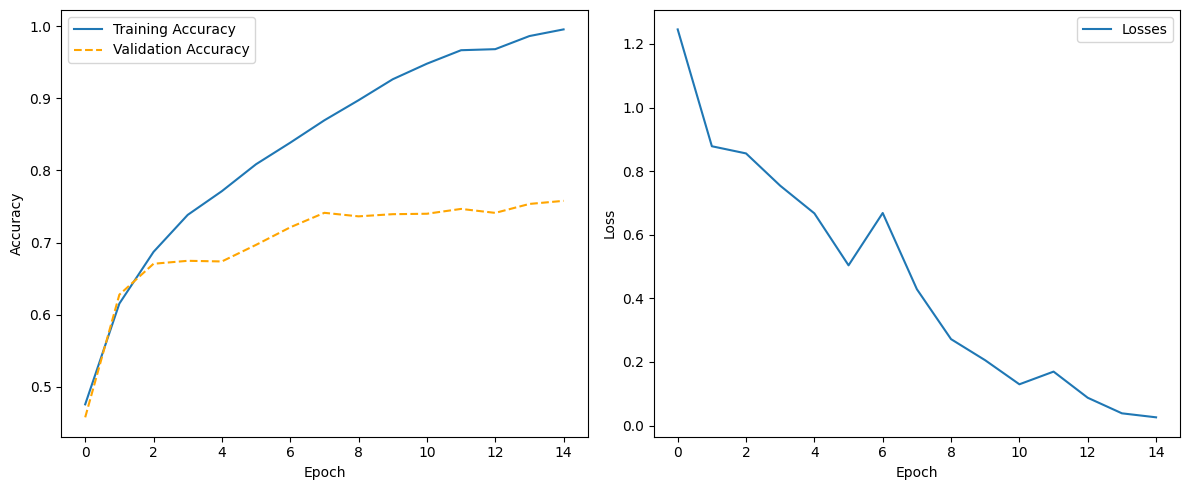

accuracy on testing data: 0.746400


In [30]:
print('Please wait patiently, it may take some time...')
# training the network
net = train(net, training_loader, validation_loader)

# test the network
acc_test = eval(net, testing_loader)

print('accuracy on testing data: %f' % acc_test)

In [55]:
# added an extra layers to the Network
class secondNetwork(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(2304, batch_size)

        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(batch_size, 256)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(256, 128)  # Adding a new fully connected layer with 128 units
        self.relu5 = nn.ReLU()
        self.fc4 = nn.Linear(128, 64) 
        self.relu6 = nn.ReLU()
        self.fc5 = nn.Linear(64, 32) 
        self.relu7 = nn.ReLU()
        self.fc6 = nn.Linear(32, num_classes) 


        
    def forward(self, x):
        x = self.conv1(x) 
        x = self.bn1(x)  
        x = self.relu1(x)  
        x = self.pool(x)

        x = self.conv2(x) 
        x = self.bn2(x)  
        x = self.relu2(x)  
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1) 

        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        x = self.relu5(x)
        x = self.fc4(x)
        x = self.relu6(x)
        x = self.fc5(x)
        x = self.relu7(x)
        x = self.fc6(x)

        return x

In [58]:
# Let's try scheduling our learning rate and see the effects
from torch.optim.lr_scheduler import StepLR

net = secondNetwork(num_classes=10)

# evaluation function with added validation loss check up
def val_eval(net, data_loader, loss_function):
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
    net.eval()
    correct = 0.0
    num_images = 0.0
    val_loss = 0.0  # Initialize val_loss
    for i_batch, (images, labels) in enumerate(data_loader):
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        outs = net(images) 
        labels = labels.long()
        loss = loss_function(outs, labels)
#         _, preds = outs.max(1)
        preds = outs.argmax(dim=1)
        correct += preds.eq(labels).sum()
        num_images += len(labels)
        val_loss += loss.item()
    
    # Calculate average validation loss
    val_loss /= len(data_loader.dataset)
    
    # Calculate validation accuracy
    val_acc = correct / num_images
    
    return val_loss, val_acc

# add a weight penalty to training, change starting learning rate
def train(net, train_loader, validation_loader):
    loss_function = torch.nn.CrossEntropyLoss()

    optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
    # scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
        
    epoches = 10
    acc_list = []
    loss_list = []
    val_acc_list = []
    val_loss_list = []
    for epoch in range(epoches):
        net.train() 
        correct = 0.0 # used to accumulate number of correctly recognized images
        num_images = 0.0 # used to accumulate number of images
        for i_batch, (images, labels) in enumerate(train_loader):
            if use_cuda:
                images = images.cuda()
                labels = labels.cuda()  # Convert labels to long type
            outs = net(images)
#             _, preds = outs.max(1)
            labels = labels.long() # make sure labels are long type
            loss = loss_function(outs, labels)

            # backward propagation
            optimizer.zero_grad() #clear old gradients
            loss.backward() #calculate gradients of parameters
            optimizer.step() #gradient descent algorithm

            preds = outs.argmax(dim=1)
            correct += preds.eq(labels).sum()
            num_images += len(labels)

            
        acc = correct / num_images
        val_loss, acc_eval = val_eval(net, validation_loader, loss_function)
        val_acc_list.append(acc_eval)
        val_loss_list.append(val_loss)
        acc_list.append(acc)
        loss_list.append(loss.item())
        # scheduler.step() # Update lr
        print('epoch: %d, lr: %f, accuracy: %f, loss: %f, valid accuracy: %f, valid loss: %f' % (epoch, optimizer.param_groups[0]['lr'], acc, loss.item(), acc_eval, val_loss))

    # Plotting accuracy and losses side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
    
    # Plot training accuracy
    axs[0].plot(acc_list, label='Training Accuracy')
    axs[0].plot(val_acc_list, label='Validation Accuracy', linestyle='dashed', color='orange')  # Dashed line for validation accuracy
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    # Plot losses
    axs[1].plot(loss_list, label='Losses')
    axs[1].plot(val_loss_list, label='Validation losses', linestyle='dashed', color='orange')  # Dashed line for validation loss
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.tight_layout()  # Ensures proper spacing between subplots
    plt.show()
    return net


Please wait patiently, it may take some seconds...
epoch: 0, lr: 0.005000, accuracy: 0.100000, loss: 2.296880, valid accuracy: 0.100000, valid loss: 0.004611
epoch: 1, lr: 0.005000, accuracy: 0.100600, loss: 2.298411, valid accuracy: 0.110900, valid loss: 0.004599
epoch: 2, lr: 0.005000, accuracy: 0.141050, loss: 2.292989, valid accuracy: 0.170100, valid loss: 0.004580
epoch: 3, lr: 0.005000, accuracy: 0.175375, loss: 2.276114, valid accuracy: 0.154100, valid loss: 0.004483
epoch: 4, lr: 0.005000, accuracy: 0.189100, loss: 1.977913, valid accuracy: 0.230400, valid loss: 0.003999
epoch: 5, lr: 0.005000, accuracy: 0.249675, loss: 1.744569, valid accuracy: 0.261700, valid loss: 0.003656
epoch: 6, lr: 0.005000, accuracy: 0.294750, loss: 1.847485, valid accuracy: 0.336400, valid loss: 0.003435
epoch: 7, lr: 0.005000, accuracy: 0.367600, loss: 1.518162, valid accuracy: 0.401700, valid loss: 0.003127
epoch: 8, lr: 0.005000, accuracy: 0.415450, loss: 1.390596, valid accuracy: 0.426000, valid l

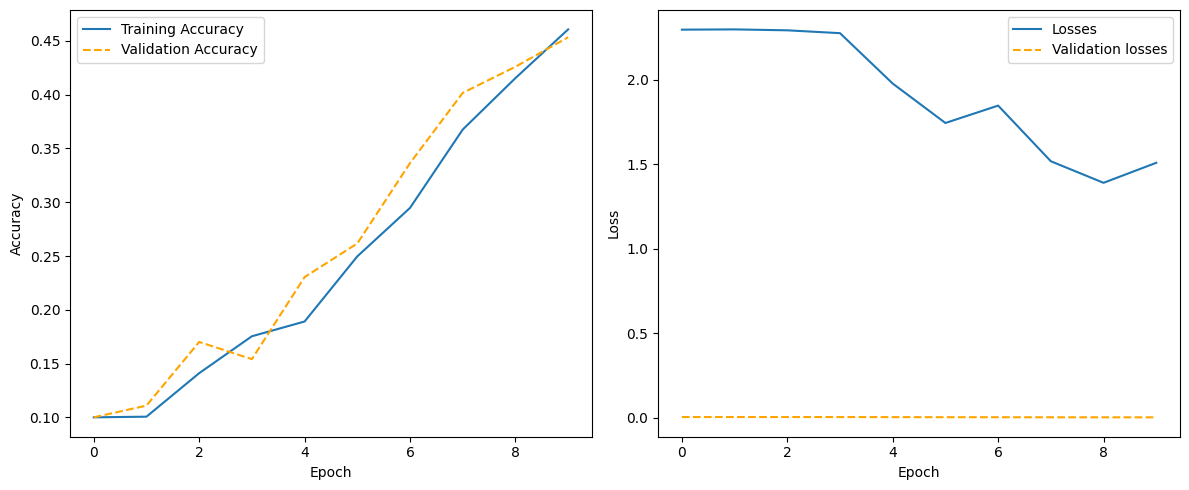

accuracy on testing data: 0.460300


In [59]:
print('Please wait patiently, it may take some seconds...')
# train the network
net = train(net, training_loader, validation_loader)

# test the network
acc_test = eval(net, testing_loader)

print('accuracy on testing data: %f' % acc_test)
